# Getting Started with MLB Player Digital Engagement Forecasting #

Welcome to the Getting Started notebook for the *MLB Digital Engagement Forecasting* competition! This notebook is a complete start-to-finish guide to entering this competition. We will:
- load and join the data,
- explore time series properties,
- create a feature set,
- train a neural network, and
- make a submission.

As this is a *code competition*, be aware that your submission will be a notebook to make predictions during the test period. Read more about [code competitions](https://www.kaggle.com/docs/competitions#notebooks-only-competitions).

In the complementary notebook, [Vertex AI with MLB Player Digital Engagement](https://www.kaggle.com/ryanholbrook/vertex-ai-with-mlb-player-digital-engagement), we'll also demonstrate some of the capabilities of **Vertex AI**, Google's new unified AI platform:
- using **Vertex AI Notebooks** on Google Cloud Platform
- exploring **Explainable AI** on Vertex AI to refine your features
- hyperparameter tuning with **Vertex Vizier**

In [8]:
import gc
import sys
import warnings
from joblib import Parallel, delayed
from pathlib import Path

import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import (CalendarFourier,
                                           CalendarSeasonality,
                                           CalendarTimeTrend,
                                           DeterministicProcess)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental.preprocessing import StringLookup

warnings.simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

# Create Training Data #

There is a lot more data available than what we'll use in this notebook. See the [data documentation](https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/data) on the competition page for a complete description the *MLB Player Digital Engagement Forecasting* competition data. And be sure to check out Google data scientist Alok Pattani's in depth data exploration: [MLB Player Digital Engagement Data Exploration](https://www.kaggle.com/alokpattani/mlb-player-digital-engagement-data-exploration).

### Read and extract dataframes

In [9]:
# Helper function to unpack json found in daily data
def unpack_json(json_str):
    return pd.DataFrame() if pd.isna(json_str) else pd.read_json(json_str)


def unpack_data(data, dfs=None, n_jobs=-1):
    if dfs is not None:
        data = data.loc[:, dfs]
    unnested_dfs = {}
    for name, column in data.iteritems():
        daily_dfs = Parallel(n_jobs=n_jobs)(
            delayed(unpack_json)(item) for date, item in column.iteritems())
        df = pd.concat(daily_dfs)
        unnested_dfs[name] = df
    return unnested_dfs

There are a number of supplementary files in addition to the training data.

In [10]:
data_dir = Path('data/raw-data/')

df_names = ['seasons', 'teams', 'players', 'awards']

for name in df_names:
    globals()[name] = pd.read_csv(data_dir / f"{name}.csv")

kaggle_data_tabs = widgets.Tab()
# Add Output widgets for each pandas DF as tabs' children
kaggle_data_tabs.children = list([widgets.Output() for df_name in df_names])

for index in range(0, len(df_names)):
    # Rename tab bar titles to df names
    kaggle_data_tabs.set_title(index, df_names[index])
    
    # Display corresponding table output for this tab name
    with kaggle_data_tabs.children[index]:
        display(eval(df_names[index]))

display(kaggle_data_tabs)

The training data is a time-indexed collection of nested JSON fields containing information about each player. The targets are contained in the `nextDayPlayerEngagement` column, while the remaining columns contain data you could use to construct features. For this getting started notebook, we'll only use features from the `playerBoxScores` dataframe.

In [11]:
%%time
# Define dataframes to load from training set
dfs = [
    'nextDayPlayerEngagement',  # targets
    'playerBoxScores',  # features
    # Other dataframes available for features:
    # 'games',
    # 'rosters',
    # 'teamBoxScores',
    # 'transactions',
    # 'standings',
    # 'awards',
    # 'events',
    # 'playerTwitterFollowers',
    # 'teamTwitterFollowers',
]

# Read training data
training = pd.read_csv(
    data_dir / 'train.csv',
    usecols=['date'] + dfs,
)

# Convert training data date field to datetime type
training['date'] = pd.to_datetime(training['date'], format="%Y%m%d")
training = training.set_index('date').to_period('D')
print(training.info())

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1216 entries, 2018-01-01 to 2021-04-30
Freq: D
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   nextDayPlayerEngagement  1216 non-null   object
 1   playerBoxScores          538 non-null    object
dtypes: object(2)
memory usage: 28.5+ KB
None
CPU times: user 12.7 s, sys: 2.84 s, total: 15.5 s
Wall time: 19.9 s


In [12]:
%time
# Unpack nested dataframes and store in dictionary `training_dfs`
training_dfs = unpack_data(training, dfs=dfs)
print('\n', training_dfs.keys())

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.06 µs

 dict_keys(['nextDayPlayerEngagement', 'playerBoxScores'])


### Construct training and validation splits

Defined in the next cell are a number of functions that will process our data into training and validation splits.

In [13]:
# Players in the test set. We'll filter our data for only this set of players
pids_test = players.playerId.loc[
    players.playerForTestSetAndFuturePreds.fillna(False)
].astype(str)

# Name of target columns
targets = ["target1", "target2", "target3", "target4"]


def make_playerBoxScores(dfs: dict, features):
    X = dfs['playerBoxScores'].copy()
    X = X[['gameDate', 'playerId'] + features]
    # Set dtypes
    X = X.astype({name: np.float32 for name in features})
    X = X.astype({'playerId': str})
    # Create date index
    X = X.rename(columns={'gameDate': 'date'})
    X['date'] = pd.PeriodIndex(X.date, freq='D')
    # Aggregate multiple games per day by summing
    X = X.groupby(['date', 'playerId'], as_index=False).sum()
    return X


def make_targets(training_dfs: dict):
    Y = training_dfs['nextDayPlayerEngagement'].copy()
    # Set dtypes
    Y = Y.astype({name: np.float32 for name in targets})
    Y = Y.astype({'playerId': str})
    # Match target dates to feature dates and create date index
    Y = Y.rename(columns={'engagementMetricsDate': 'date'})
    Y['date'] = pd.to_datetime(Y['date'])
    Y = Y.set_index('date').to_period('D')
    Y.index = Y.index - 1
    return Y.reset_index()


def join_datasets(dfs):
    dfs = [x.pivot(index='date', columns='playerId') for x in dfs]
    df = pd.concat(dfs, axis=1).stack().reset_index('playerId')
    return df


def make_training_data(training_dfs: dict,
                       features,
                       targets,
                       fourier=4,
                       test_size=30):
    # Process dataframes
    X = make_playerBoxScores(training_dfs, features)
    Y = make_targets(training_dfs)
    # Merge for processing
    df = join_datasets([X, Y])
    # Filter for players in test set
    df = df.loc[df.playerId.isin(pids_test), :]
    # Convert from long to wide format
    df = df.pivot(columns="playerId")
    # Restore features and targets
    X = df.loc(axis=1)[features, :]
    Y = df.loc(axis=1)[targets, :]
    # Fill missing values in features
    X.fillna(-1, inplace=True)
    # Create temporal features
    fourier_terms = CalendarFourier(freq='A', order=fourier)
    deterministic = DeterministicProcess(
        index=X.index,
        order=0,
        seasonal=False,  # set to True for weekly seasonality
        additional_terms=[fourier_terms],
    )
    X = pd.concat([X, deterministic.in_sample()], axis=1)
    # Create train / validation splits
    X_train, X_valid, y_train, y_valid = train_test_split(
        X,
        Y,
        test_size=test_size,
        shuffle=False,
    )
    return X_train, X_valid, y_train, y_valid, deterministic

In this cell we'll define the features we want to use from `playerBoxScores`. This frame contains player statistics for every game in the training period. We've chosen just a few from the many available. The `make_training_data` function also adjoins some features modeling annual seasonality, motivated by our data exploration in the next section.

In [14]:
%%time
# Columns to select from playerBoxScores, all numeric
features = [
    "hits",
    "strikeOuts",
    "homeRuns",
    "runsScored",
    "stolenBases",
    "strikeOutsPitching",
    "inningsPitched",
    "strikes",
    "flyOuts",
    "groundOuts",
    "errors",
]

# Number of days to use for the validation set
test_size = 30

X_train, X_valid, y_train, y_valid, deterministic = make_training_data(
    training_dfs, 
    features=features, 
    targets=targets,
    fourier=4,  # number of Fourier pairs describing annual seasonality
    test_size=test_size,
)

CPU times: user 16.6 s, sys: 2.62 s, total: 19.2 s
Wall time: 22 s


# Data Exploration #

In [15]:
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette(
        "husl",
        n_colors=X[period].nunique(),
    )
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual",
            "Semiannual",
            "Quarterly",
            "Bimonthly",
            "Monthly",
            "Biweekly",
            "Weekly",
            "Semiweekly",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Density")
    ax.set_title("Periodogram")
    return ax

A *seasonal plot* can reveal seasonal effects in a time series. Let's look at seasonal plots for players in the top 10% of average engagement, one for yearly seasonality and one for weekly seasonality.

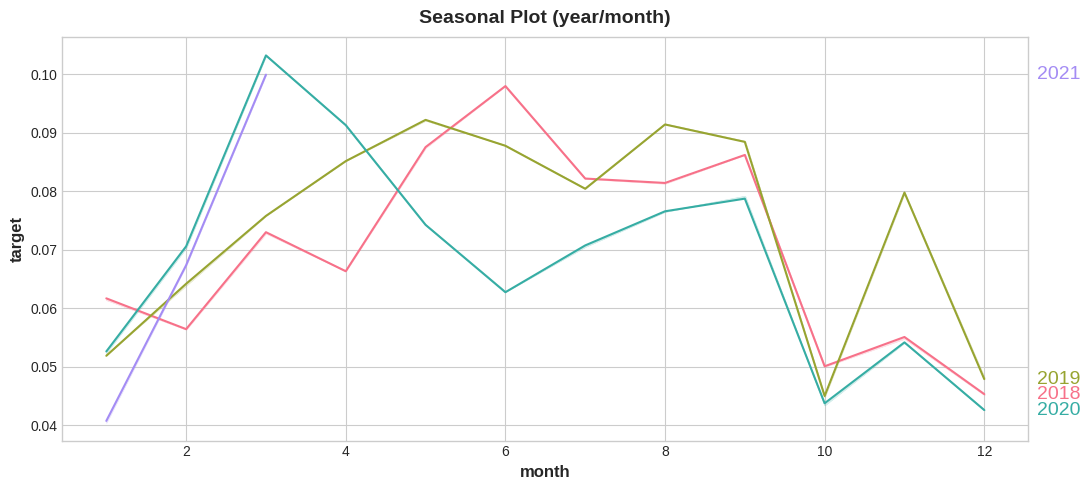

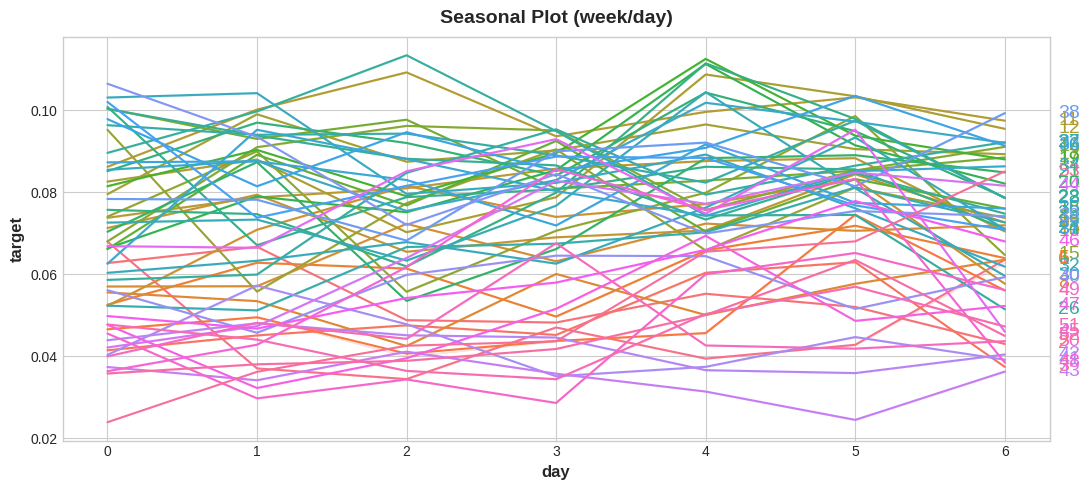

In [16]:
# Select players in top decile of engagement
deciles = pd.qcut(y_train.mean().mean(level=1), q=10)
pids_top_decile = deciles.index[deciles == deciles.max()]
y_top_decile = y_train.loc(axis=1)[:, pids_top_decile]

# Create average engagement series
y_top_decile_avg = (y_top_decile / y_top_decile.max(axis=0)).mean(axis=1)
y_top_decile_avg.name = "target"

# Yearly plot
S = y_top_decile_avg.to_frame()
S["month"] = S.index.month  # the frequency
S["year"] = S.index.year  # the period
_ = seasonal_plot(S, y="target", period="year", freq="month")

# Weekly plot
S = y_top_decile_avg.to_frame()
S["day"] = S.index.dayofweek  # the frequency
S["week"] = S.index.week  # the period
_ = seasonal_plot(S, y="target", period="week", freq="day")

From these plots, digital player engagement appears to have a strong annual component, but little or no weekly component.

We can verify this with the *periodogram*. The periodogram illustrates the strength of the frequencies within a signal -- specifically, the variance of the sine / cosine Fourier component oscillating at that frequency.

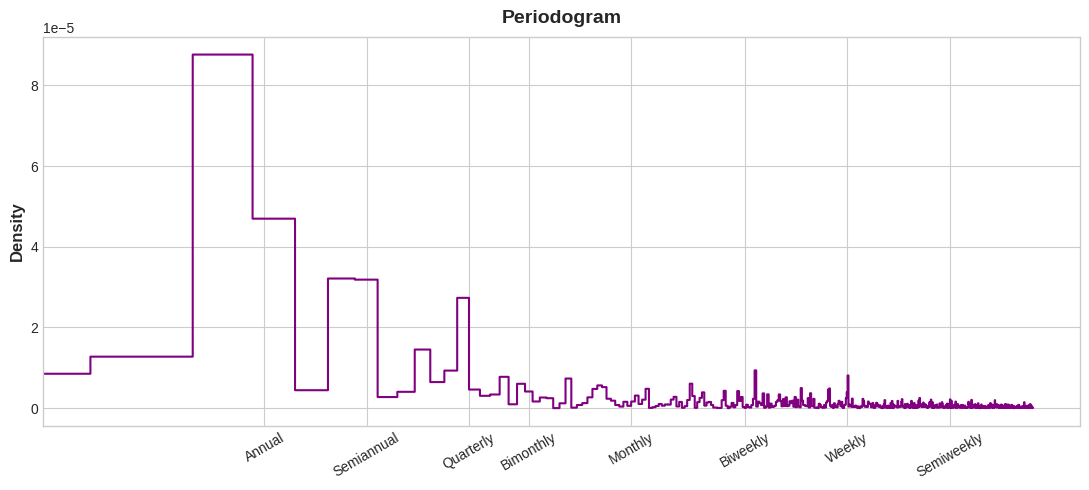

In [17]:
_ = plot_periodogram(y_top_decile_avg)

Both of these visualizations indicate yearly (or annual) seasonality in the engagement time series, which motivated our decision to use yearly Fourier features when constructing our feature set.

# Model #

For this getting started notebook, we'll just use a simple feedforward network.

In [18]:
# Hyperparameters
HIDDEN = 1024
ACTIVATION = 'relu'  # could try elu, gelu, swish
DROPOUT_RATE = 0.5
LEARNING_RATE = 1e-2
BATCH_SIZE = 32

OUTPUTS = y_train.shape[-1]
model = keras.Sequential([
    layers.Dense(HIDDEN, activation=ACTIVATION),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(HIDDEN, activation=ACTIVATION),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(HIDDEN, activation=ACTIVATION),
    layers.BatchNormalization(),
    layers.Dropout(DROPOUT_RATE),
    layers.Dense(OUTPUTS),
])

2023-02-15 08:50:04.191787: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-15 08:50:04.192415: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-15 08:50:04.192449: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gianlucca-Lenovo-IdeaPad-S145-15IWL): /proc/driver/nvidia/version does not exist
2023-02-15 08:50:04.195141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
%%time
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='mae', metrics=['mae'])

early_stopping = keras.callbacks.EarlyStopping(patience=3)

history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=BATCH_SIZE,
    epochs=100,
    callbacks=[early_stopping],
)

Epoch 1/100
38/38 [==============================] - 11s 238ms/step - loss: 1.9944 - mae: 1.9944 - val_loss: 73.8554 - val_mae: 73.8554
Epoch 2/100
38/38 [==============================] - 9s 226ms/step - loss: 1.7345 - mae: 1.7345 - val_loss: 6.8394 - val_mae: 6.8394
Epoch 3/100
38/38 [==============================] - 9s 228ms/step - loss: 1.5862 - mae: 1.5862 - val_loss: 2.1781 - val_mae: 2.1781
Epoch 4/100
38/38 [==============================] - 8s 223ms/step - loss: 1.4423 - mae: 1.4423 - val_loss: 2.0744 - val_mae: 2.0744
Epoch 5/100
38/38 [==============================] - 9s 228ms/step - loss: 1.3581 - mae: 1.3581 - val_loss: 1.9395 - val_mae: 1.9395
Epoch 6/100
38/38 [==============================] - 9s 234ms/step - loss: 1.3030 - mae: 1.3030 - val_loss: 1.8672 - val_mae: 1.8672
Epoch 7/100
38/38 [==============================] - 10s 254ms/step - loss: 1.2745 - mae: 1.2745 - val_loss: 1.7834 - val_mae: 1.7834
Epoch 8/100
38/38 [==============================] - 9s 237ms/ste

# Create Submission #

The next cell illustrates how you to create a submission for this competition. As this is a code competition that relies on a time series module, submissions must follow the requirements described on the [Evaluation Page](https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/overview/evaluation) and [Data Page](https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/data).

In [20]:
def make_test_data(test_dfs: dict, features, deterministic):
    X = make_playerBoxScores(test_dfs, features)
    X = X.merge(pids_test, how='right')
    X['date'] = X.date.fillna(method='ffill').fillna(method='bfill')
    X.fillna(-1, inplace=True)
    # Convert from long to wide format
    X = X.pivot(index='date', columns="playerId")
    # Create temporal features
    X = pd.concat([
        X,
        deterministic.out_of_sample(steps=1, forecast_index=X.index),
    ],
                  axis=1)
    return X


def make_predictions(model, X, columns, targets):
    y_pred = model.predict(X)
    y_pred = pd.DataFrame(y_pred, columns=columns, index=X.index).stack()
    y_pred[targets] = y_pred[targets].clip(0, 100)
    y_pred['date_playerId'] = [
        (date + 1).strftime('%Y%m%d') + '_' + str(playerId)
        for date, playerId in y_pred.index
    ]
    y_pred.reset_index('playerId', drop=True, inplace=True)
    y_pred = y_pred[['date_playerId'] + targets]  # reorder
    y_pred.index = pd.Int64Index(
        [int(date.strftime('%Y%m%d')) for date in y_pred.index], name='date')
    return y_pred

In [21]:
%%time
import mlb

env = mlb.make_env()
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
    # Unpack features from test_df
    test_dfs = unpack_data(test_df, dfs=['playerBoxScores'])
    X = make_test_data(test_dfs, features, deterministic)

    # Create predictions
    y_pred = make_predictions(
        model,
        X,
        columns=y_train.columns,
        targets=targets,
    )
    submission = (
        sample_prediction_df
        [['date_playerId']]
        .reset_index()  #  preserve index 'date'
        .merge(y_pred, how='left', on='date_playerId')
        .set_index('date')  #  restore index 'date'
    )

    # Submit predictions
    env.predict(submission)  # constructs submissions.csv

ModuleNotFoundError: No module named 'mlb'

To complete a submission for this competition, we'll need to commit this notebook and submit the resulting submission file it creates,`submissions.csv`. From the notebook editor:
- make sure *Internet* is turned off in **Settings**,
- click the **Save Version** button to the upper right,
- make sure *Save and Run All (Commit)* is selected, and
- click **Save**.

Once the commit completes (should only be three or four minutes):
- select from the menubar **File -> Version History**,
- select from the ellipsis menu of the latest version **... -> Submit to Competition**, and
- click **Submit**

Kaggle will rerun the notebook on the public test set and display the score on the public leaderboard. [**My Submissions**](https://www.kaggle.com/c/mlb-player-digital-engagement-forecasting/submissions) will show the status of the submission: currently running, succeeded, or failed.

The submission requirements for code competitions can be somewhat exacting. If you're having trouble, checkout our [**Code Competitions - Errors & Debugging Tips**](https://www.kaggle.com/docs/competitions#notebooks-only-FAQ).

# Explainable AI and Hyperparameter Tuning with Vertex #

[This complementary notebook](https://www.kaggle.com/ryanholbrook/vertex-ai-with-mlb-player-digital-engagement) demonstrates how to run this notebook in Vertex AI Notebooks. You'll learn how to use **Explainable AI (XAI)** to refine your features and how to tune your model with **Vertex Vizier**.